In [22]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import patches as mpatches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy


import metpy.calc as mpcalc
from metpy.units import units

# Preprocessing

## Functions

In [3]:
ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"


boxNH = [[-100, -70, 12 , 20],
         [-80 , -60, 8  , 16],
         [70  , 90 , 2  , 18],
         [100 , 120, 8  , 20],
         [118 , 140, 4  , 20],
         [100 , 110, 0  , 12],
        ]

boxSH = [[20  , 50 , -20, 0 ],
         [-60 , -30, -20, 0 ],
        ]

boxNH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxNH]
boxSH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxSH]

namesNH = ["Central America",
           "Venezuela",
           "South Asia",
           "Vietnam / South China Sea",
           "Philippines",
           "Malaysia"
          ]
namesSH = ["Tanzania",
           "NorthEast Brazil"
          ]

In [14]:
#Data extraction from ERA5
era5yrs = list(range(1979,2019))

def retrieve_era5(year,varid):
    """gather an ERA5 monthly mean variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    try :
        era5var = xr.open_dataset(glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0])
    except IndexError :
        path = "/global/cscratch1/sd/qnicolas/era5monthly/"
        era5var = xr.open_dataset(glob.glob(os.path.join(path,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0])
    varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    
    return era5var[varname]

def climatology_era5(varid,level=-1):
    varlist = []
    for year in era5yrs:
        if level>=0:
            varlist.append(retrieve_era5(year,varid).sel(level=level))
        else :
            varlist.append(retrieve_era5(year,varid))
    return xr.concat(varlist, "time").groupby("time.month").mean("time")

def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean

def region_mean2D_trmm(variable,mask,box):
    mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean


## Masks, data

In [5]:
def slide_coord(mask):
    """Switch the longitude coord from (-180,180) to (0,360) 
    and change coordinate names from 'LAT1','LON1' to 'latitude' and 'longitude'"""
    mask0=mask.copy()
    mask0.coords['longitude'] = mask0.coords['LON1']%360
    mask1 = mask0.swap_dims({'LON1': 'longitude'}).rename({'LAT1': 'latitude'})

    #Sort the longitude values
    sort_inds = {"longitude": np.argsort(mask1["longitude"].values)}
    mask1 = mask1.isel(**sort_inds)
    return mask1

#masks = xr.open_dataset("/global/cscratch1/sd/qnicolas/masks/winter_rainfall_masks.nc")
masks = xr.open_dataset("winter_rainfall_masks.nc")
trmm_nh_winter_mask = masks.TRMM_NH_WINTER_MASK.fillna(0.)
trmm_sh_winter_mask = masks.TRMM_SH_WINTER_MASK.fillna(0.)

REFERENCE_GRID = xr.open_dataset(ERA5M_PATH+"e5.moda.an.pl/e5.moda.an.pl.128_060_pv.ll025sc.1979010100_1979120100.nc").PV.sel(latitude=slice(50., -50.)).isel(time=0) #to get the era5 grid

trmm_nh_winter_mask1 = (slide_coord(trmm_nh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_sh_winter_mask1 = (slide_coord(trmm_sh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.   
trmm_nh_winter_mask = slide_coord(trmm_nh_winter_mask)
trmm_sh_winter_mask = slide_coord(trmm_sh_winter_mask)

In [6]:
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
landmask50=(landmask.interp_like(REFERENCE_GRID) > 0)*1.


In [23]:
t=time.time()
all_sst = climatology_era5('128_034_sstk')
all_cape = climatology_era5('128_059_cape')
print(time.time()-t)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


48.811599254608154


In [7]:
all_pr_trmm=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
all_pr_trmm=all_pr_trmm.groupby("time.month").mean("time")


In [9]:
landmaskBIS = np.isnan(all_sst.sel(month=1,latitude=slice(50,-50)))

# Plots in May/November

In [68]:
def plot_boxes(ax):
    for i,b in enumerate(boxNH1+boxSH1):
        ax.add_patch(mpatches.Rectangle(xy=[b[0], b[2]], width=b[1]-b[0], height=b[3]-b[2],
                                        edgecolor='w',
                                        fill = False,
                                        lw=0.5,
                                        transform=ccrs.PlateCarree())
                     )

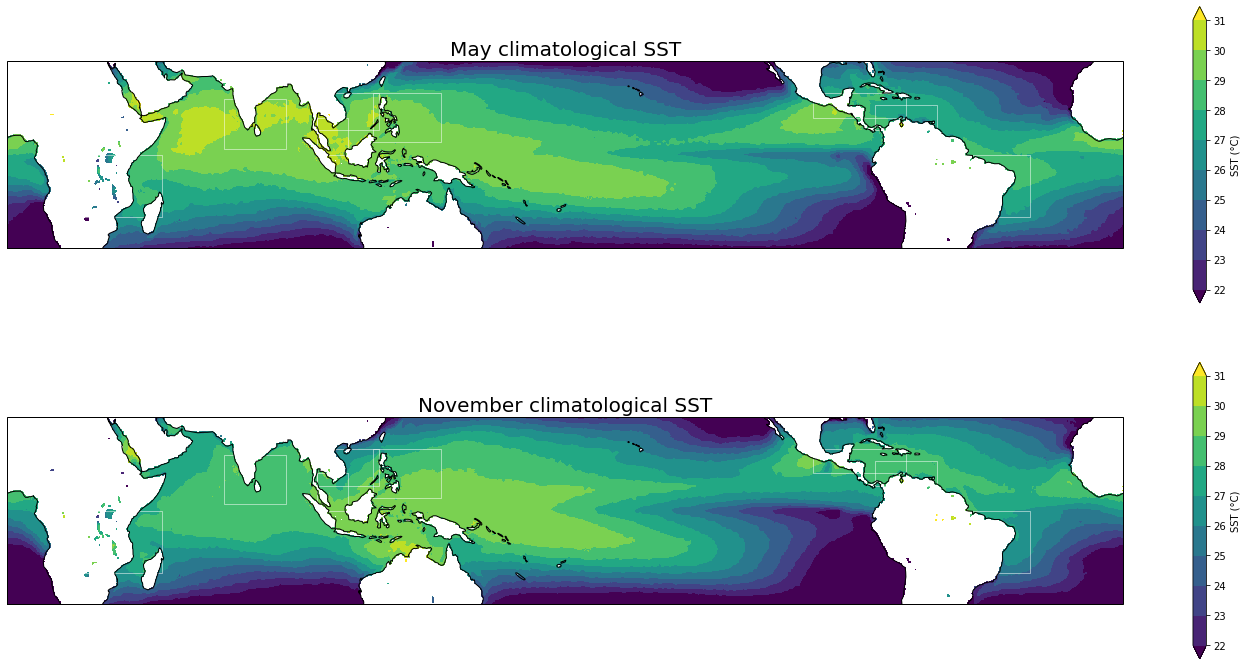

In [69]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(25,12),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

(all_sst-273.15).sel(month=5,latitude = slice(30,-30)).plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"SST (°C)"},levels=np.arange(22,32,1))#,"ticks":np.arange(-0.02,0.021,0.004)}
(all_sst-273.15).sel(month=11,latitude = slice(30,-30)).plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"SST (°C)"},levels=np.arange(22,32,1))
ax1.set_title("May climatological SST",fontsize=20)
ax2.set_title("November climatological SST" ,fontsize=20)
ax1.coastlines();ax2.coastlines()
plot_boxes(ax1);plot_boxes(ax2);

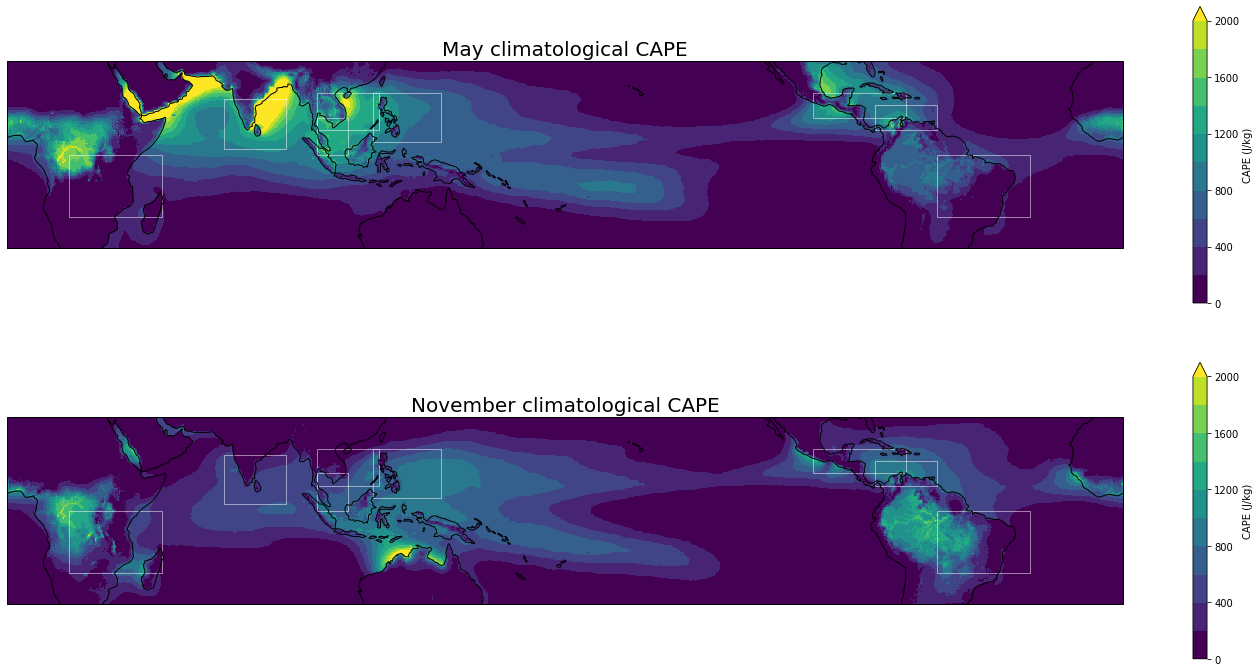

In [70]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(25,12),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

all_cape.sel(month=5,latitude = slice(30,-30)).plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label": "CAPE (J/kg)"},levels=np.arange(0,2001,200))
all_cape.sel(month=11,latitude = slice(30,-30)).plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"CAPE (J/kg)"},levels=np.arange(0,2001,200))
ax1.set_title("May climatological CAPE",fontsize=20)
ax2.set_title("November climatological CAPE" ,fontsize=20)
ax1.coastlines();ax2.coastlines()
plot_boxes(ax1);plot_boxes(ax2);

# SST/CAPE seasonal variation plots

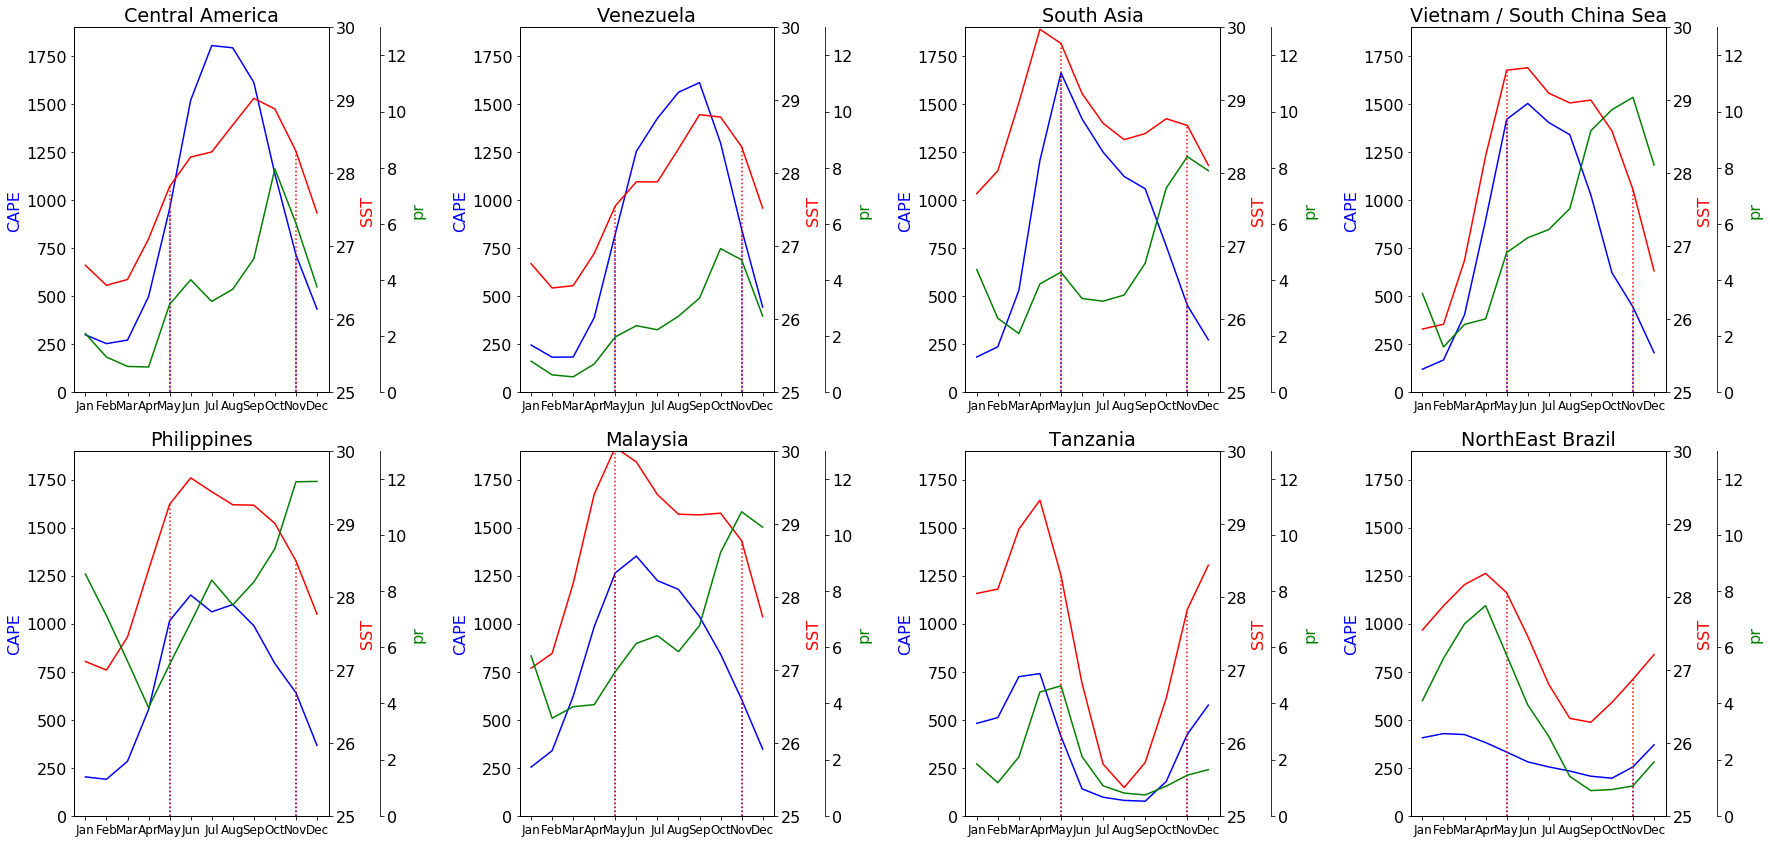

In [63]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)

mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
        mask2 = trmm_nh_winter_mask
    else :
        mask = trmm_sh_winter_mask1
        mask2 = trmm_sh_winter_mask
    cape=region_mean2D(all_cape,mask,box)
    sst=region_mean2D(all_sst-273.15,mask*(1-landmaskBIS),box)
    ax[i].plot(mnths,cape,'b',label="CAPE")
    ax[i].set_title((namesNH+namesSH)[i])
    ax[i].set_ylim(0,1900);ax[i].set_ylabel('CAPE',color="b")
    ax[i].plot([4,4],[0,cape[4]],':b'   )
    ax[i].plot([10,10],[0,cape[10]],':b')
    
    ax2=ax[i].twinx()
    ax2.set_ylim(25,30);ax2.set_ylabel('SST', color='r')
    ax2.plot([4,4],  [0,sst[4]],':r'   )
    ax2.plot([10,10],[0,sst[10]],':r')
    ax2.plot(mnths,sst,'r')
    
    pr=region_mean2D_trmm(all_pr_trmm,mask2,box)
    ax3=ax[i].twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    #make_patch_spines_invisible(ax3)
    #ax3.spines["right"].set_visible(True)
    ax3.set_ylim(0,13);
    ax3.set_ylabel('pr', color='g')
    ax3.plot(mnths,pr,color='g')

matplotlib.rcParams.update({'font.size': 16})
for a in ax : a.tick_params(axis = 'x', which = 'major', labelsize = 12)
fig.tight_layout()

# Upslope flow / moisture flux seasonal variation plots - spatially averaged

In [8]:
#OROGRAPHY
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

#latitude step in era5
dx5 = np.abs(np.array(ddxorog.latitude.isel(latitude=1)-ddxorog.latitude.isel(latitude=0)))


In [12]:
t=time.time()
u100m_era5 = climatology_era5('228_246_100u')
v100m_era5 = climatology_era5('228_247_100v')
ugradz_era5 = (u100m_era5 *ddxorog + v100m_era5 *ddyorog)
print(time.time()-t)
q925_era5  = xr.open_dataset("e5.moda.an.sfc.q925.1979_2019_mean.nc")#climatology_era5('128_133_q',level=925.)
q925_ugradz_era5  = q925_era5 *ugradz_era5 
print(time.time()-t)

In [15]:
t=time.time()
viwve_era5  = climatology_era5('162_071_viwve')
viwvn_era5  = climatology_era5('162_072_viwvn')
viwvgradz_era5  = (viwve_era5 *ddxorog + viwvn_era5 *ddyorog)
print(time.time()-t)

49.25261306762695


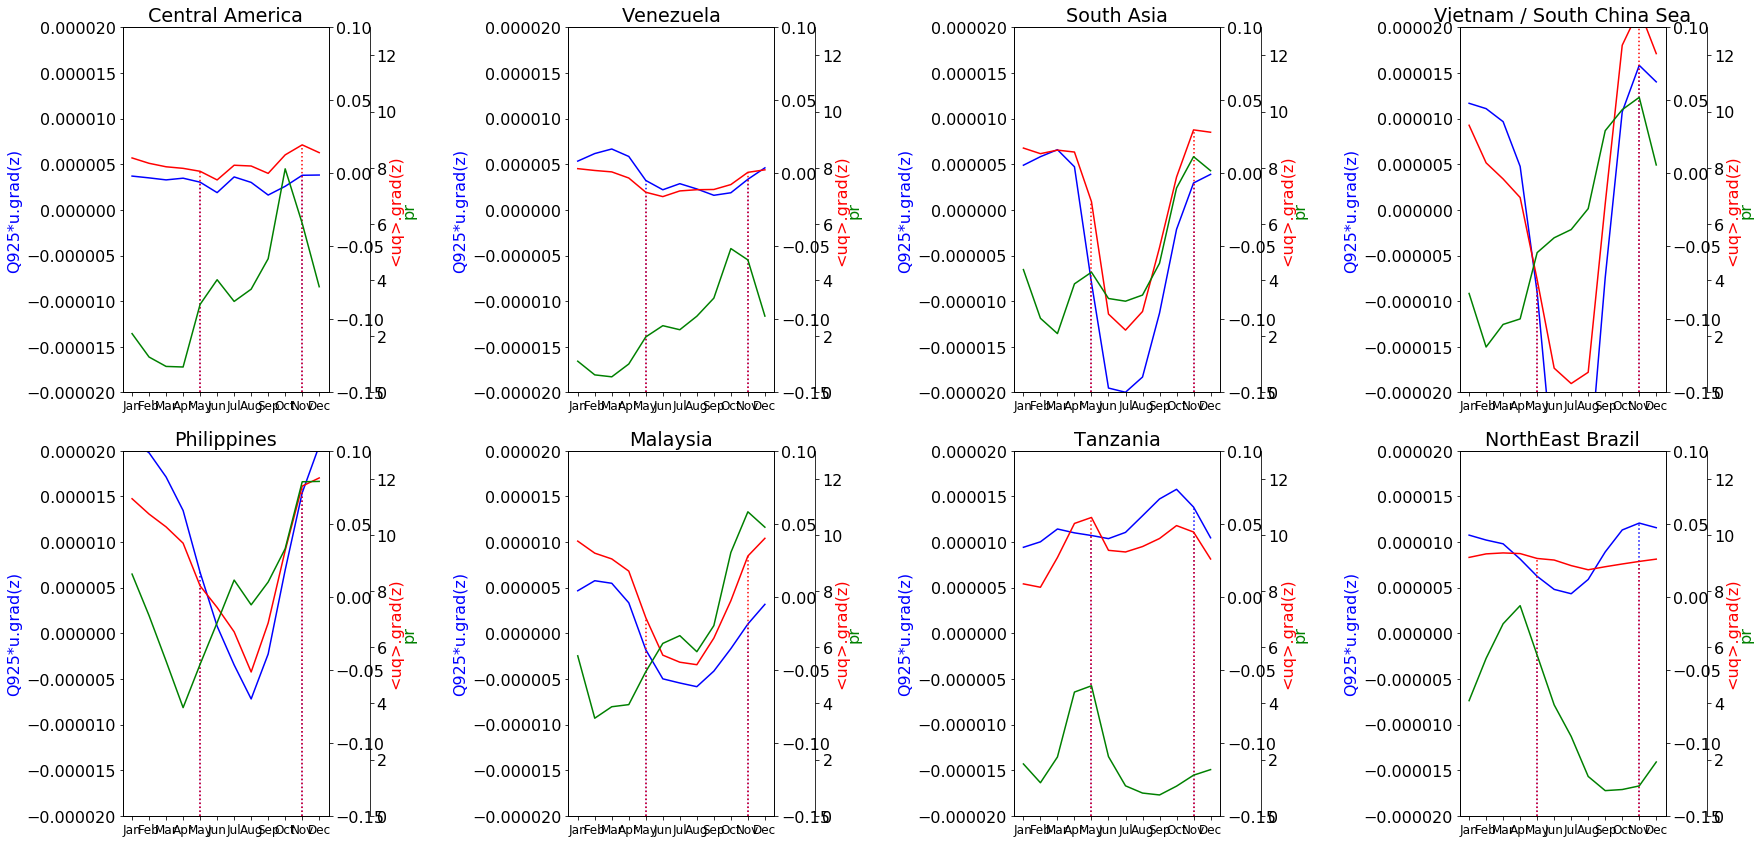

In [19]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)

mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
        mask2 = trmm_nh_winter_mask
    else :
        mask = trmm_sh_winter_mask1
        mask2 = trmm_sh_winter_mask
    q925_ugradz=region_mean2D(q925_ugradz_era5,mask,box)
    vimtgradz=region_mean2D(vimtgradz_era5,mask,box)
    
    ax[i].plot(mnths,q925_ugradz,'b',label="Q925*u.grad(z)")
    ax[i].set_title((namesNH+namesSH)[i])
    ax[i].set_ylim(-2e-5,2e-5);ax[i].set_ylabel('Q925*u.grad(z)',color="b")
    ax[i].plot([4,4],  [-2e-5,q925_ugradz[4]],':b'   )
    ax[i].plot([10,10],[-2e-5,q925_ugradz[10]],':b')
    
    ax2=ax[i].twinx()
    ax2.set_ylim(-0.15,0.10);ax2.set_ylabel('<uq>.grad(z)', color='r')
    ax2.plot([4,4],  [-0.15,vimtgradz[4]],':r'   )
    ax2.plot([10,10],[-0.15,vimtgradz[10]],':r')
    ax2.plot(mnths,vimtgradz,'r')
    
    pr=region_mean2D_trmm(all_pr_trmm,mask2,box)
    ax3=ax[i].twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    #make_patch_spines_invisible(ax3)
    #ax3.spines["right"].set_visible(True)
    ax3.set_ylim(0,13);
    ax3.set_ylabel('pr', color='g')
    ax3.plot(mnths,pr,color='g')

matplotlib.rcParams.update({'font.size': 16})
for a in ax : a.tick_params(axis = 'x', which = 'major', labelsize = 12)
fig.tight_layout()

# Upslope moisture flux seasonal variation plots - spatially integrated over positive points (with CAPE and precip overlayed)

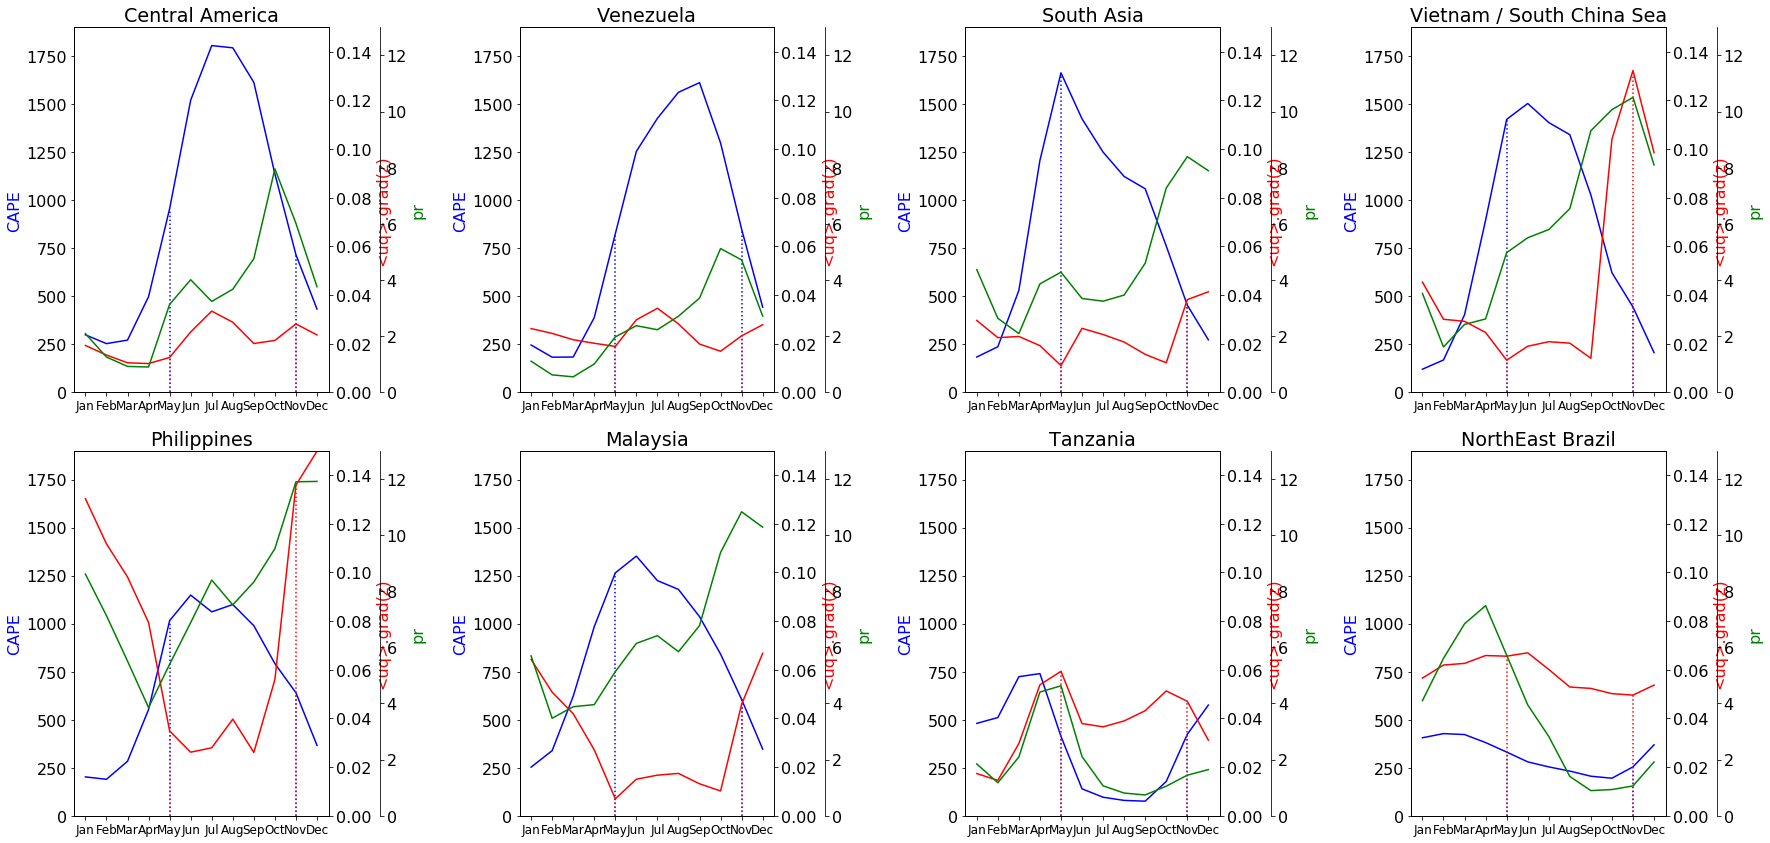

In [25]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)

mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
        mask2 = trmm_nh_winter_mask
    else :
        mask = trmm_sh_winter_mask1
        mask2 = trmm_sh_winter_mask
    cape=region_mean2D(all_cape,mask,box)
    vimtgradz=region_mean2D(vimtgradz_era5*(vimtgradz_era5>0.),mask,box)
    
    ax[i].plot(mnths,cape,'b',label="CAPE")
    ax[i].set_title((namesNH+namesSH)[i])
    ax[i].set_ylim(0.,1900.);ax[i].set_ylabel('CAPE',color="b")
    ax[i].plot([4,4],  [0.,cape[4]],':b'   )
    ax[i].plot([10,10],[0.,cape[10]],':b')
    
    ax2=ax[i].twinx()
    ax2.set_ylim(0.,0.15);ax2.set_ylabel('<uq>.grad(z)', color='r')
    ax2.plot([4,4],  [0.,vimtgradz[4]],':r'   )
    ax2.plot([10,10],[0.,vimtgradz[10]],':r')
    ax2.plot(mnths,vimtgradz,'r')
    
    pr=region_mean2D_trmm(all_pr_trmm,mask2,box)
    ax3=ax[i].twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    #make_patch_spines_invisible(ax3)
    #ax3.spines["right"].set_visible(True)
    ax3.set_ylim(0,13);
    ax3.set_ylabel('pr', color='g')
    ax3.plot(mnths,pr,color='g')

matplotlib.rcParams.update({'font.size': 16})
for a in ax : a.tick_params(axis = 'x', which = 'major', labelsize = 12)
fig.tight_layout()